# Find the fingerprints of ENSO and the IPO in observed gridded datasets

Purpose
-------

    1.    Decompose the temperature time series into Intrinsic Mode Functions (IMFs) using EMD.
            i)  remove monthly climatology
            ii) remove linear trend over timeseries
    2.    Identify and correlate relevant IMFs with known indices for ENSO and IPO.
    3.    Compute slope of relationship between ENSO/IPO and variable of interest to quantify effect of ENSO/IPO


### IMPORTS

In [1]:

import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# oceanographic
import gsw as gsw

# statistics
import scipy as sci
from scipy.signal import hilbert, periodogram
from PyEMD import EMD, CEEMDAN

# regridding package
import xesmf as xe

# Copernicus marine toolbox
#import copernicusmarine
#from pprint import pprint
#copernicusmarine.login()

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


/g/data/es60/pjb581/miniforge3/envs/pyEMD_env/lib/python3.10/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.1
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

## Load the MLD dataset

In [2]:
%%time

mld = xr.open_dataset("/g/data/es60/pjb581/SPC/data/EN4_mld_2005-2024.nc")['mld']


CPU times: user 83.5 ms, sys: 36.8 ms, total: 120 ms
Wall time: 593 ms


## Take the monthly anomaly in MLDs

CPU times: user 158 ms, sys: 144 ms, total: 302 ms
Wall time: 307 ms


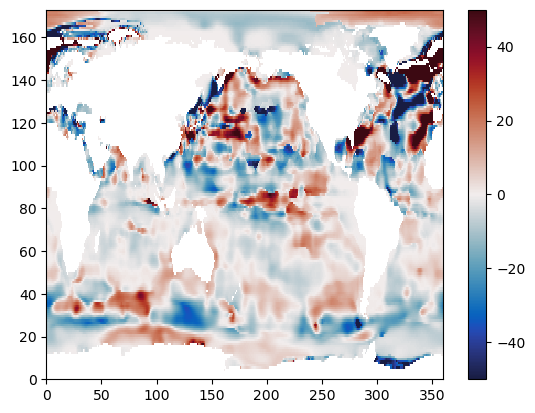

In [3]:
%%time


mld_clim = mld.groupby('time.month').mean('time')
mld_anom = mld.groupby('time.month') - mld_clim

plt.figure()
plt.pcolormesh(mld_anom.isel(time=0), cmap=cmo.balance, vmin=-50, vmax=50)
plt.colorbar()


## detrend the MLD dataset

In [4]:
%%time

### remove global trend
def detrend_1d(arr):
    """Remove the linear trend from a 1D array."""
    x = np.arange(len(arr))
    # Fit a linear trend
    coeffs = np.polyfit(x, arr, 1)
    trend = np.polyval(coeffs, x)
    # Remove the trend
    detrended = arr - trend
    return detrended

mld_detr = xr.apply_ufunc(
    detrend_1d,
    mld_anom,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[mld_anom.dtype]
)



CPU times: user 10.9 s, sys: 841 ms, total: 11.8 s
Wall time: 10.8 s


## determine the linear trends since 2005

CPU times: user 109 ms, sys: 28.8 ms, total: 138 ms
Wall time: 136 ms


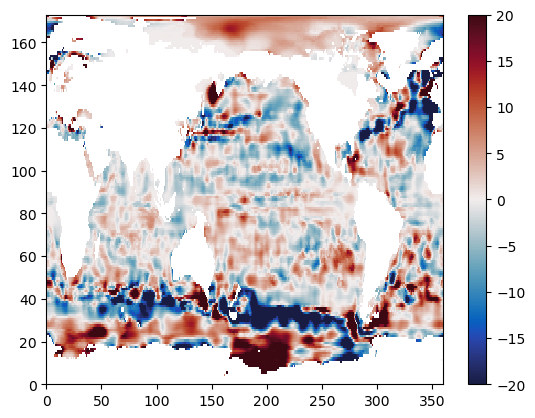

In [5]:
%%time

### retrive the linear least squares trend
mld_trend = mld_anom - mld_detr

### since the trends are linear, they can be described by one number (their slope)
### calculate the slope on a decadal timescale
dates = mld_anom.coords['time']
mld_trend = mld_trend.sel(time=dates[-1]) - mld_trend.sel(time=dates[0]) / len(dates) * 12 * 10

plt.figure()
plt.pcolormesh(mld_trend, cmap=cmo.balance, vmin=-20, vmax=20)
plt.colorbar()


## Undertake the decomposition at each grid cell across the ocean

In [6]:
%%time
from joblib import Parallel, delayed
from scipy.signal import periodogram, hilbert

# Setup CEEMDAN config
def make_ceemdan():
    ceemdan = CEEMDAN()
    ceemdan.noise_seed = 42
    ceemdan.num_siftings = 100
    ceemdan.Nstd = 0.2
    ceemdan.trials = 100
    return ceemdan

# Setup
years = np.arange(2005+0.5/12, 2024+11.51/12, 1/12)
times = mld_anom.coords['time'].values
lats = mld_anom.coords['lat'].values
lons = mld_anom.coords['lon'].values

def find_imf_freq_Hilbert(imfs, years):
    inst_freqs = []
    for imf in imfs:
        analytic_signal = hilbert(imf)
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi * np.diff(years))
        inst_freqs.append(instantaneous_frequency)
    return np.array([np.mean(freq) for freq in inst_freqs])


def find_weights_from_freqs(imfs, bands):
    fs = 12  # Hz (cycles per year)
    n_imfs, n_time = imfs.shape
    n_bands = len(bands)
    weights = np.zeros((n_bands, n_imfs))

    # find the frequency power spectra of the different IMFs
    freqs = []
    power = []
    for i in range(n_imfs):
        f, p = periodogram(imfs[i,:], fs=fs, scaling='density', window='hann')
        freqs.append(f)
        power.append(p)
    freqs = np.array(freqs); power = np.array(power)
    
    # find the weights associated with that power spectra
    for i in range(n_imfs):
        total_power = np.sum(power[i,:])
        for j, (f_min, f_max) in enumerate(bands):
            mask = (freqs[i,:] >= f_min) & (freqs[i,:] < f_max)
            band_power = np.sum(power[i][mask])
            weights[j, i] = band_power / total_power if total_power > 0 else 0.0

    return weights
    

def set_bands(imfs, weights):
    return weights @ imfs


# Processing function for each grid cell
def process_cell(ix, iy):
    ceemdan = make_ceemdan()  # Create fresh CEEMDAN instance (safe in parallel)
    signal = mld_detr.isel(lon=ix, lat=iy).values
    if not np.all(np.isfinite(signal)):
        return (ix, iy, None)
    try:
        imfs = ceemdan(signal)
        weights = find_weights_from_freqs(imfs, bands)
        grouped = set_bands(imfs, weights)
        return (ix, iy, grouped)
    except Exception as e:
        print(f"Error at ({ix}, {iy}): {e}")
        return (ix, iy, None)


CPU times: user 39 ms, sys: 48.9 ms, total: 87.8 ms
Wall time: 3.02 s


## run for MLD

In [ ]:
%%time

# Predefined cut-offs for frequency bands
bands = [
    (1.0, np.inf),       # Subannual
    (0.15, 1.0),         # Interannual
    (0.01, 0.15),        # Decadal
    (-np.inf, 0.01)       # Centennial or more
]

# Coordinate pairs
ntime = len(times)
nlat = len(lats)
nlon = len(lons)
coords = [(ix, iy) for ix in range(nlon) for iy in range(nlat)]

# Run in parallel
results = Parallel(n_jobs=56, backend='loky', verbose=2)(
    delayed(process_cell)(ix, iy) for (ix, iy) in coords
)


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done  50 tasks      | elapsed:   10.7s
[Parallel(n_jobs=56)]: Done 253 tasks      | elapsed:   22.4s
[Parallel(n_jobs=56)]: Done 536 tasks      | elapsed:   42.6s
[Parallel(n_jobs=56)]: Done 901 tasks      | elapsed:  1.2min
[Parallel(n_jobs=56)]: Done 1346 tasks      | elapsed:  1.6min


In [8]:
%%time

mld_imfs = np.zeros((4,len(times),len(lats),len(lons)))

# Assemble results
for ix, iy, grouped in results:
    if grouped is not None:
        mld_imfs[:, :, iy, ix] = grouped
        

CPU times: user 551 ms, sys: 371 ms, total: 922 ms
Wall time: 919 ms


In [11]:
%%time

# Create xarray Datasets
imfs_mld_ds = xr.Dataset(
    {
        "mld_imfs": (["IMF", "time", "lat", "lon"], mld_imfs),
        "mld_anom": (["time", "lat", "lon"], mld_anom.values),
        "mld_detr": (["time", "lat", "lon"], mld_detr.transpose("time", "lat", "lon").values),
        "mld_trend": (["lat", "lon"], mld_trend.values),
    },
    coords={
        "IMF": np.arange(1,5,1),
        "time": dates,
        "lat": lats,
        "lon": lons,
    },
)
os.chdir(wrkdir + "/data/")
#os.remove("imfs_mld_CEEMDAN.nc")
imfs_mld_ds.to_netcdf("imfs_mld_CEEMDAN.nc")


CPU times: user 320 ms, sys: 1.1 s, total: 1.42 s
Wall time: 2.11 s
